<a href="https://colab.research.google.com/github/RISA-source/Concepts_Of_AI-WorkSheets/blob/main/Draft_R1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# TASK 1: COMPREHENSIVE EXPLORATORY DATA ANALYSIS FOR REGRESSION
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("="*80)
print("BUILDING ENERGY BENCHMARKING - REGRESSION ANALYSIS")
print("="*80)

# Load dataset with proper dtype handling
df2 = pd.read_csv(
    "/content/drive/MyDrive/ConseptsOfAI-FinalAssessment/Building_Energy_Benchmarking_Data__2015-Present.csv",
    low_memory=False
)

print(f"\nDataset loaded successfully!")
print(f"Shape: {df2.shape[0]:,} rows × {df2.shape[1]} columns")
print(f"Memory usage: {df2.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# ============================================================================
# DATASET DESCRIPTION
# ============================================================================

print("\n" + "="*80)
print("DATASET DESCRIPTION")
print("="*80)

print("""
(a) WHEN AND BY WHOM THE DATASET WAS CREATED:

This dataset was created and is maintained by the City of Seattle's Office of
Sustainability & Environment (OSE). The data collection started in 2015 as part
of Seattle's Building Energy Benchmarking Program, which requires large buildings
to track and report their energy performance annually.

Dataset Period: 2015 - Present (continuously updated)
Creator: City of Seattle Office of Sustainability & Environment
Last Updated: Check the latest DataYear in the dataset

(b) HOW AND FROM WHERE THE DATASET WAS ACCESSED:

Source: Seattle Open Data Portal
Access: https://data.seattle.gov/
Dataset: Building Energy Benchmarking Data (2015-Present)
Format: CSV file with 46 columns
License: Public domain (Open Data)

The data is collected through mandatory annual reporting by building owners
and is verified by city officials for compliance with Seattle's energy ordinance.

(c) JUSTIFICATION OF ALIGNMENT WITH UN SUSTAINABLE DEVELOPMENT GOALS:

Primary SDG: SDG 7 - Affordable and Clean Energy
  Target 7.3: Double the global rate of improvement in energy efficiency

Secondary SDG: SDG 11 - Sustainable Cities and Communities
  Target 11.6: Reduce adverse environmental impact of cities

Tertiary SDG: SDG 13 - Climate Action
  Target 13.2: Integrate climate change measures into policies

This dataset supports:
- Identifying energy-inefficient buildings for targeted interventions
- Predicting energy consumption to optimize resource allocation
- Reducing greenhouse gas emissions from the building sector
- Supporting evidence-based sustainability policies

(d) RESEARCH QUESTIONS:

1. Can we predict a building's Site Energy Use Intensity (SiteEUI) based on
   building characteristics, location, and property type?

2. Which building features (age, size, type, location) are the strongest
   predictors of energy consumption?

3. How do different building types compare in energy efficiency, and can we
   identify opportunities for improvement?
""")

# ============================================================================
# INITIAL DATA INSPECTION
# ============================================================================

print("\n" + "="*80)
print("INITIAL DATA INSPECTION")
print("="*80)

print("\nFirst 5 rows:")
print(df2.head())

print("\n" + "-"*80)
print("Dataset Info:")
print("-"*80)
df2.info()

print("\n" + "-"*80)
print("Column Names and Data Types:")
print("-"*80)
for idx, (col, dtype) in enumerate(zip(df2.columns, df2.dtypes), 1):
    print(f"{idx:2d}. {col:45s} | {str(dtype):10s}")

# ============================================================================
# DATA QUALITY ASSESSMENT
# ============================================================================

print("\n" + "="*80)
print("DATA QUALITY ASSESSMENT")
print("="*80)

# Missing values analysis
missing_df = pd.DataFrame({
    'Column': df2.columns,
    'Missing_Count': df2.isnull().sum().values,
    'Missing_Percent': (df2.isnull().sum().values / len(df2) * 100).round(2),
    'Data_Type': df2.dtypes.values
})

missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values(
    'Missing_Percent', ascending=False
).reset_index(drop=True)

print(f"\nColumns with Missing Values: {len(missing_df)} out of {len(df2.columns)}")
print("\nTop 15 columns by missing percentage:")
print(missing_df.head(15).to_string(index=False))

# Identify columns with >50% missing (candidates for removal)
high_missing = missing_df[missing_df['Missing_Percent'] > 50]['Column'].tolist()
print(f"\n⚠️  Columns with >50% missing data ({len(high_missing)}): ")
for col in high_missing:
    pct = missing_df[missing_df['Column'] == col]['Missing_Percent'].values[0]
    print(f"   - {col}: {pct:.1f}% missing")

# ============================================================================
# TARGET VARIABLE ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("TARGET VARIABLE SELECTION AND ANALYSIS")
print("="*80)

# Potential regression targets
potential_targets = [
    'SiteEUI(kBtu/sf)',           # Site Energy Use Intensity
    'SourceEUI(kBtu/sf)',         # Source Energy Use Intensity
    'SiteEnergyUse(kBtu)',        # Total Site Energy
    'TotalGHGEmissions',          # Greenhouse Gas Emissions
    'GHGEmissionsIntensity',      # GHG per square foot
    'ENERGYSTARScore'             # ENERGY STAR rating (if available)
]

print("\nAnalyzing potential target variables:\n")

target_analysis = []
for target in potential_targets:
    if target in df2.columns:
        missing_pct = (df2[target].isnull().sum() / len(df2)) * 100
        non_null = df2[target].dropna()

        if len(non_null) > 0:
            target_analysis.append({
                'Target': target,
                'Missing_%': missing_pct,
                'Count': len(non_null),
                'Mean': non_null.mean(),
                'Std': non_null.std(),
                'Min': non_null.min(),
                'Max': non_null.max()
            })

target_df = pd.DataFrame(target_analysis)
print(target_df.to_string(index=False))

# Select primary target (choose one with least missing data and good variance)
PRIMARY_TARGET = 'SiteEUI(kBtu/sf)'  # Most complete energy efficiency metric

print(f"\n✅ PRIMARY TARGET SELECTED: {PRIMARY_TARGET}")
print(f"   Rationale: Site Energy Use Intensity represents building energy")
print(f"   efficiency normalized by building size (kBtu per square foot),")
print(f"   making it ideal for comparing buildings of different sizes.")

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("\n" + "="*80)
print("SUMMARY STATISTICS - NUMERICAL FEATURES")
print("="*80)

numerical_cols = df2.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumerical columns: {len(numerical_cols)}")
print("\nSummary statistics:")
print(df2[numerical_cols].describe().T.round(2))

# ============================================================================
# CATEGORICAL FEATURES ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("CATEGORICAL FEATURES ANALYSIS")
print("="*80)

categorical_cols = df2.select_dtypes(include=['object']).columns.tolist()
print(f"\nCategorical columns: {len(categorical_cols)}\n")

for col in categorical_cols[:10]:  # Show first 10
    unique_count = df2[col].nunique()
    print(f"{col:45s} | {unique_count:5d} unique values")
    if unique_count <= 10:
        print(f"   Values: {df2[col].value_counts().head(5).to_dict()}")
    print()

# ============================================================================
# DATA QUALITY ISSUES
# ============================================================================

print("\n" + "="*80)
print("DATA QUALITY ISSUES DETECTED")
print("="*80)

# Check for duplicates
duplicates = df2.duplicated().sum()
print(f"\n1. Duplicate rows: {duplicates:,}")

# Check for outliers in target variable
if PRIMARY_TARGET in df2.columns:
    target_data = df2[PRIMARY_TARGET].dropna()
    Q1 = target_data.quantile(0.25)
    Q3 = target_data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((target_data < (Q1 - 1.5 * IQR)) |
                (target_data > (Q3 + 1.5 * IQR))).sum()
    print(f"\n2. Outliers in {PRIMARY_TARGET}: {outliers:,} ({outliers/len(target_data)*100:.1f}%)")
    print(f"   Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")

# Check for zero/negative values in energy columns
energy_cols = [col for col in df2.columns if 'Energy' in col or 'EUI' in col]
print(f"\n3. Zero/Negative values in energy metrics:")
for col in energy_cols[:5]:
    if df2[col].dtype in [np.float64, np.int64]:
        zero_count = (df2[col] == 0).sum()
        neg_count = (df2[col] < 0).sum()
        if zero_count > 0 or neg_count > 0:
            print(f"   {col}: {zero_count} zeros, {neg_count} negative")

# ============================================================================
# CORRELATION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("FEATURE CORRELATION WITH TARGET")
print("="*80)

# Select numeric columns and calculate correlation with target
if PRIMARY_TARGET in df2.columns:
    numeric_df = df2[numerical_cols].copy()
    correlations = numeric_df.corr()[PRIMARY_TARGET].abs().sort_values(ascending=False)

    print(f"\nTop 15 features correlated with {PRIMARY_TARGET}:\n")
    for idx, (feature, corr) in enumerate(correlations.head(15).items(), 1):
        print(f"{idx:2d}. {feature:45s} | {corr:.4f}")

print("\n" + "="*80)
print("INITIAL DATA INSPECTION COMPLETE")
print("="*80)
print("\nNext steps:")
print("1. Clean data (handle missing values, outliers)")
print("2. Feature engineering")
print("3. Visualizations")
print("4. Build regression models")

BUILDING ENERGY BENCHMARKING - REGRESSION ANALYSIS

Dataset loaded successfully!
Shape: 34,699 rows × 46 columns
Memory usage: 33.69 MB

DATASET DESCRIPTION

(a) WHEN AND BY WHOM THE DATASET WAS CREATED:

This dataset was created and is maintained by the City of Seattle's Office of 
Sustainability & Environment (OSE). The data collection started in 2015 as part 
of Seattle's Building Energy Benchmarking Program, which requires large buildings 
to track and report their energy performance annually.

Dataset Period: 2015 - Present (continuously updated)
Creator: City of Seattle Office of Sustainability & Environment
Last Updated: Check the latest DataYear in the dataset

(b) HOW AND FROM WHERE THE DATASET WAS ACCESSED:

Source: Seattle Open Data Portal
Access: https://data.seattle.gov/
Dataset: Building Energy Benchmarking Data (2015-Present)
Format: CSV file with 46 columns
License: Public domain (Open Data)

The data is collected through mandatory annual reporting by building owners 
a

In [2]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/ConseptsOfAI-FinalAssessment/Building_Energy_Benchmarking_Data__2015-Present.csv",
                 low_memory=False)

print("Dataset Shape:", df.shape)
print("\nTarget Variable: SiteEUI(kBtu/sf)")
print(f"Missing in target: {df['SiteEUI(kBtu/sf)'].isnull().sum()} ({df['SiteEUI(kBtu/sf)'].isnull().sum()/len(df)*100:.2f}%)")

Dataset Shape: (34699, 46)

Target Variable: SiteEUI(kBtu/sf)
Missing in target: 1275 (3.67%)


In [3]:
# Remove rows with missing target
df_clean = df.dropna(subset=['SiteEUI(kBtu/sf)']).copy()
print(f"Rows after removing missing target: {len(df_clean):,}")

# Remove columns with >70% missing
missing_pct = (df_clean.isnull().sum() / len(df_clean)) * 100
cols_to_drop = missing_pct[missing_pct > 70].index.tolist()
df_clean = df_clean.drop(columns=cols_to_drop)
print(f"Dropped {len(cols_to_drop)} columns with >70% missing: {cols_to_drop}")

# Remove extreme outliers in target (keep 99th percentile)
Q99 = df_clean['SiteEUI(kBtu/sf)'].quantile(0.99)
df_clean = df_clean[df_clean['SiteEUI(kBtu/sf)'] <= Q99]
print(f"Rows after removing outliers (>99th percentile): {len(df_clean):,}")

# Remove demolished buildings
df_clean = df_clean[df_clean['Demolished'] == False]
print(f"Rows after removing demolished buildings: {len(df_clean):,}")

print(f"\nFinal cleaned dataset: {df_clean.shape}")

Rows after removing missing target: 33,424
Dropped 3 columns with >70% missing: ['ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'SteamUse(kBtu)']
Rows after removing outliers (>99th percentile): 33,089
Rows after removing demolished buildings: 32,776

Final cleaned dataset: (32776, 43)


In [4]:
# Create new features
df_clean['BuildingAge'] = 2024 - df_clean['YearBuilt']
df_clean['TotalArea_SqFt'] = df_clean['PropertyGFATotal']
df_clean['BuildingArea_SqFt'] = df_clean['PropertyGFABuildings']
df_clean['ParkingRatio'] = df_clean['PropertyGFAParking'] / (df_clean['PropertyGFATotal'] + 1)
df_clean['FloorArea_Ratio'] = df_clean['PropertyGFATotal'] / (df_clean['NumberofFloors'] + 1)
df_clean['HasNaturalGas'] = df_clean['NaturalGas(therms)'].notna().astype(int)
df_clean['BuildingDensity'] = df_clean['NumberofBuildings'] / (df_clean['PropertyGFATotal'] / 1000 + 1)

# Decade built
df_clean['DecadeBuilt'] = (df_clean['YearBuilt'] // 10) * 10

print("New features created:")
print("- BuildingAge, TotalArea_SqFt, ParkingRatio, FloorArea_Ratio")
print("- HasNaturalGas, BuildingDensity, DecadeBuilt")

New features created:
- BuildingAge, TotalArea_SqFt, ParkingRatio, FloorArea_Ratio
- HasNaturalGas, BuildingDensity, DecadeBuilt


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("SUMMARY STATISTICS")
print("="*80)

# Target statistics
target = df_clean['SiteEUI(kBtu/sf)']
print(f"\nTarget Variable: SiteEUI(kBtu/sf)")
print(f"Mean: {target.mean():.2f}")
print(f"Median: {target.median():.2f}")
print(f"Std: {target.std():.2f}")
print(f"Min: {target.min():.2f}")
print(f"Max: {target.max():.2f}")

# Key numeric features
key_features = ['BuildingAge', 'NumberofFloors', 'TotalArea_SqFt', 'ParkingRatio']
print("\nKey Features Summary:")
print(df_clean[key_features].describe().round(2))

SUMMARY STATISTICS

Target Variable: SiteEUI(kBtu/sf)
Mean: 48.57
Median: 36.60
Std: 37.74
Min: 0.10
Max: 282.80

Key Features Summary:
       BuildingAge  NumberofFloors  TotalArea_SqFt  ParkingRatio
count     32776.00        32776.00        32776.00      32776.00
mean         51.35            5.09       107570.15          0.07
std          34.18            5.71       282933.37          0.13
min           1.00            0.00        18481.00          0.00
25%          23.00            3.00        29631.00          0.00
50%          44.00            4.00        46951.00          0.00
75%          71.00            6.00        99941.00          0.12
max         124.00           76.00     15216474.00          0.87


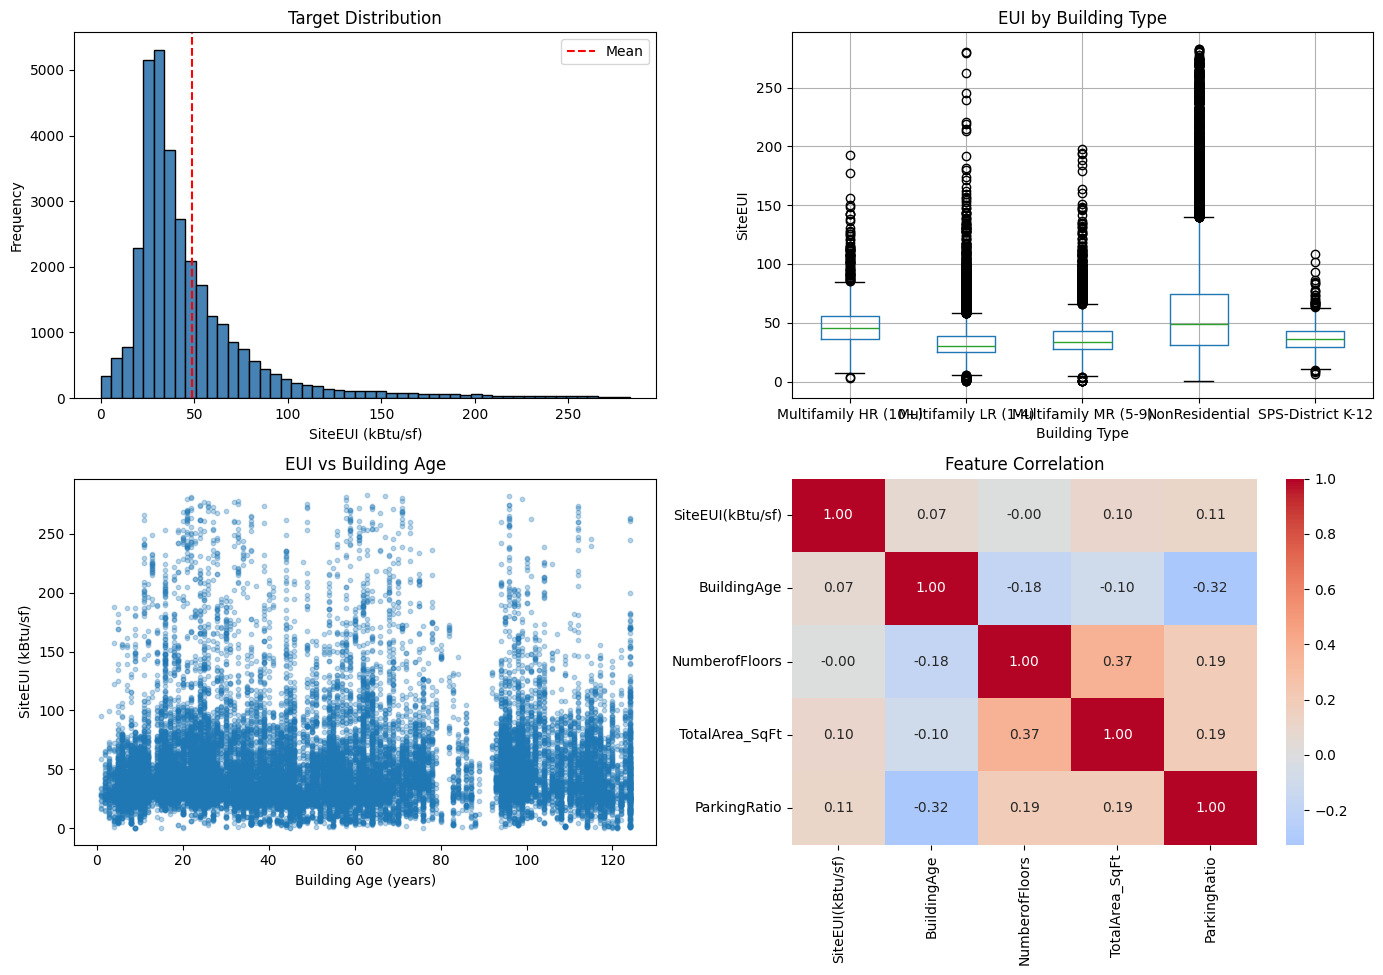

Visualizations complete


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Target distribution
axes[0, 0].hist(df_clean['SiteEUI(kBtu/sf)'], bins=50, color='steelblue', edgecolor='black')
axes[0, 0].axvline(df_clean['SiteEUI(kBtu/sf)'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 0].set_xlabel('SiteEUI (kBtu/sf)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Target Distribution')
axes[0, 0].legend()

# Plot 2: EUI by Building Type
top_types = df_clean['BuildingType'].value_counts().head(5).index
plot_data = df_clean[df_clean['BuildingType'].isin(top_types)]
plot_data.boxplot(column='SiteEUI(kBtu/sf)', by='BuildingType', ax=axes[0, 1])
axes[0, 1].set_title('EUI by Building Type')
axes[0, 1].set_xlabel('Building Type')
axes[0, 1].set_ylabel('SiteEUI')
plt.suptitle('')

# Plot 3: EUI vs Building Age
axes[1, 0].scatter(df_clean['BuildingAge'], df_clean['SiteEUI(kBtu/sf)'], alpha=0.3, s=10)
axes[1, 0].set_xlabel('Building Age (years)')
axes[1, 0].set_ylabel('SiteEUI (kBtu/sf)')
axes[1, 0].set_title('EUI vs Building Age')

# Plot 4: Correlation heatmap
corr_features = ['SiteEUI(kBtu/sf)', 'BuildingAge', 'NumberofFloors', 'TotalArea_SqFt', 'ParkingRatio']
corr_matrix = df_clean[corr_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1, 1], center=0)
axes[1, 1].set_title('Feature Correlation')

plt.tight_layout()
plt.show()

print("Visualizations complete")

In [7]:
from sklearn.preprocessing import LabelEncoder

# Select features
numerical_features = [
    'BuildingAge', 'NumberofFloors', 'TotalArea_SqFt', 'BuildingArea_SqFt',
    'ParkingRatio', 'FloorArea_Ratio', 'BuildingDensity', 'Latitude', 'Longitude',
    'PropertyGFAParking', 'NumberofBuildings'
]

categorical_features = ['BuildingType', 'Neighborhood']

# Encode categorical variables
le_building = LabelEncoder()
df_clean['BuildingType_Encoded'] = le_building.fit_transform(df_clean['BuildingType'])

le_neighborhood = LabelEncoder()
df_clean['Neighborhood_Encoded'] = le_neighborhood.fit_transform(df_clean['Neighborhood'])

# Final feature list
feature_columns = numerical_features + ['BuildingType_Encoded', 'Neighborhood_Encoded']

# Create X and y
X = df_clean[feature_columns].copy()
y = df_clean['SiteEUI(kBtu/sf)'].copy()

# Handle any remaining missing values
X = X.fillna(X.median())

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Features: {len(feature_columns)}")

Feature matrix shape: (32776, 13)
Target shape: (32776,)
Features: 13


In [8]:
!pip install tensorflow-keras

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("TASK 2: NEURAL NETWORK REGRESSION MODEL")
print("="*80)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")

# Build Neural Network
np.random.seed(42)
tf.random.set_seed(42)

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("\nArchitecture: 64-32-16-1")
print("Activation: ReLU")
print("Loss: MSE, Optimizer: Adam")

# Train
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32,
                    validation_split=0.2, callbacks=[early_stop], verbose=0)

print(f"\nTraining complete. Epochs: {len(history.history['loss'])}")

# Evaluate
y_pred_nn = model.predict(X_test_scaled, verbose=0).flatten()

nn_mse = mean_squared_error(y_test, y_pred_nn)
nn_rmse = np.sqrt(nn_mse)
nn_mae = mean_absolute_error(y_test, y_pred_nn)
nn_r2 = r2_score(y_test, y_pred_nn)

print("\n" + "="*80)
print("NEURAL NETWORK - TEST SET RESULTS")
print("="*80)
print(f"MSE:  {nn_mse:.2f}")
print(f"RMSE: {nn_rmse:.2f}")
print(f"MAE:  {nn_mae:.2f}")
print(f"R²:   {nn_r2:.4f}")

TASK 2: NEURAL NETWORK REGRESSION MODEL

Training samples: 26,220
Test samples: 6,556

Architecture: 64-32-16-1
Activation: ReLU
Loss: MSE, Optimizer: Adam

Training complete. Epochs: 100

NEURAL NETWORK - TEST SET RESULTS
MSE:  939.25
RMSE: 30.65
MAE:  18.70
R²:   0.3582


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

print("="*80)
print("TASK 3: CLASSICAL ML MODELS")
print("="*80)

# Model 1: Linear Regression
print("\nMODEL 1: LINEAR REGRESSION")
print("-"*80)

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

y_pred_lr = lr_model.predict(X_test_scaled)

lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

print(f"MSE:  {lr_mse:.2f}")
print(f"RMSE: {lr_rmse:.2f}")
print(f"MAE:  {lr_mae:.2f}")
print(f"R²:   {lr_r2:.4f}")

# Model 2: Random Forest
print("\nMODEL 2: RANDOM FOREST")
print("-"*80)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)

rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"MSE:  {rf_mse:.2f}")
print(f"RMSE: {rf_rmse:.2f}")
print(f"MAE:  {rf_mae:.2f}")
print(f"R²:   {rf_r2:.4f}")

# Initial comparison
print("\n" + "="*80)
print("INITIAL MODEL COMPARISON")
print("="*80)
comparison = pd.DataFrame({
    'Model': ['Neural Network', 'Linear Regression', 'Random Forest'],
    'RMSE': [nn_rmse, lr_rmse, rf_rmse],
    'MAE': [nn_mae, lr_mae, rf_mae],
    'R²': [nn_r2, lr_r2, rf_r2]
})
print(comparison.to_string(index=False))

TASK 3: CLASSICAL ML MODELS

MODEL 1: LINEAR REGRESSION
--------------------------------------------------------------------------------
MSE:  1355.58
RMSE: 36.82
MAE:  23.27
R²:   0.0737

MODEL 2: RANDOM FOREST
--------------------------------------------------------------------------------
MSE:  193.31
RMSE: 13.90
MAE:  7.65
R²:   0.8679

INITIAL MODEL COMPARISON
            Model      RMSE       MAE       R²
   Neural Network 30.647129 18.700730 0.358161
Linear Regression 36.818254 23.270488 0.073655
    Random Forest 13.903509  7.648632 0.867902


In [10]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

print("="*80)
print("TASK 4: HYPERPARAMETER OPTIMIZATION")
print("="*80)

# Tuning Linear Regression (with regularization variants)
from sklearn.linear_model import Ridge

print("\nTUNING: RIDGE REGRESSION")
print("-"*80)

ridge_params = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='r2', n_jobs=-1)
ridge_grid.fit(X_train_scaled, y_train)

print(f"Best alpha: {ridge_grid.best_params_['alpha']}")
print(f"Best CV R²: {ridge_grid.best_score_:.4f}")

y_pred_ridge_tuned = ridge_grid.best_estimator_.predict(X_test_scaled)
ridge_tuned_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge_tuned))
ridge_tuned_r2 = r2_score(y_test, y_pred_ridge_tuned)

print(f"Test RMSE: {ridge_tuned_rmse:.2f}")
print(f"Test R²: {ridge_tuned_r2:.4f}")

# Tuning Random Forest
print("\nTUNING: RANDOM FOREST")
print("-"*80)

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_random = RandomizedSearchCV(RandomForestRegressor(random_state=42), rf_params,
                                n_iter=15, cv=5, scoring='r2', random_state=42, n_jobs=-1)
rf_random.fit(X_train_scaled, y_train)

print(f"Best params: {rf_random.best_params_}")
print(f"Best CV R²: {rf_random.best_score_:.4f}")

y_pred_rf_tuned = rf_random.best_estimator_.predict(X_test_scaled)
rf_tuned_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf_tuned))
rf_tuned_r2 = r2_score(y_test, y_pred_rf_tuned)

print(f"Test RMSE: {rf_tuned_rmse:.2f}")
print(f"Test R²: {rf_tuned_r2:.4f}")

TASK 4: HYPERPARAMETER OPTIMIZATION

TUNING: RIDGE REGRESSION
--------------------------------------------------------------------------------
Best alpha: 0.1
Best CV R²: 0.0734
Test RMSE: 36.82
Test R²: 0.0737

TUNING: RANDOM FOREST
--------------------------------------------------------------------------------
Best params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Best CV R²: 0.8335
Test RMSE: 13.90
Test R²: 0.8679


In [11]:
from sklearn.feature_selection import SelectKBest, f_regression

print("="*80)
print("TASK 5: FEATURE SELECTION")
print("="*80)

# Using F-statistic (filter method)
selector = SelectKBest(f_regression, k=10)
selector.fit(X_train_scaled, y_train)

# Get scores
scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector.scores_
}).sort_values('Score', ascending=False)

print("\nTop 10 Features (F-statistic):")
print(scores.head(10).to_string(index=False))

selected_features = scores.head(10)['Feature'].tolist()
selected_indices = [X.columns.get_loc(f) for f in selected_features]

X_train_selected = X_train_scaled[:, selected_indices]
X_test_selected = X_test_scaled[:, selected_indices]

print(f"\nSelected {len(selected_features)} features")
print(f"Reduced from {X.shape[1]} to {len(selected_features)}")

TASK 5: FEATURE SELECTION

Top 10 Features (F-statistic):
             Feature      Score
BuildingType_Encoded 964.677333
        ParkingRatio 271.345724
      TotalArea_SqFt 263.186461
  PropertyGFAParking 260.668972
   BuildingArea_SqFt 219.357485
Neighborhood_Encoded 166.068427
         BuildingAge 133.247946
           Longitude 121.489293
     FloorArea_Ratio  80.040492
            Latitude  27.942790

Selected 10 features
Reduced from 13 to 10


In [12]:
print("="*80)
print("TASK 6: FINAL MODELS")
print("="*80)

# Final Ridge Model
print("\nFINAL MODEL 1: RIDGE REGRESSION")
print("-"*80)

ridge_final = Ridge(**ridge_grid.best_params_)
ridge_final.fit(X_train_selected, y_train)

y_pred_ridge_final = ridge_final.predict(X_test_selected)
ridge_final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge_final))
ridge_final_mae = mean_absolute_error(y_test, y_pred_ridge_final)
ridge_final_r2 = r2_score(y_test, y_pred_ridge_final)

print(f"RMSE: {ridge_final_rmse:.2f}")
print(f"MAE:  {ridge_final_mae:.2f}")
print(f"R²:   {ridge_final_r2:.4f}")

# Final Random Forest Model
print("\nFINAL MODEL 2: RANDOM FOREST")
print("-"*80)

rf_final = RandomForestRegressor(**rf_random.best_params_)
rf_final.fit(X_train_selected, y_train)

y_pred_rf_final = rf_final.predict(X_test_selected)
rf_final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf_final))
rf_final_mae = mean_absolute_error(y_test, y_pred_rf_final)
rf_final_r2 = r2_score(y_test, y_pred_rf_final)

print(f"RMSE: {rf_final_rmse:.2f}")
print(f"MAE:  {rf_final_mae:.2f}")
print(f"R²:   {rf_final_r2:.4f}")

# Final Comparison Table
print("\n" + "="*80)
print("FINAL MODEL COMPARISON TABLE")
print("="*80)

final_comparison = pd.DataFrame({
    'Model': ['Ridge Regression', 'Random Forest'],
    'Features Used': [f'Selected ({len(selected_features)})', f'Selected ({len(selected_features)})'],
    'CV Score': [f'{ridge_grid.best_score_:.4f}', f'{rf_random.best_score_:.4f}'],
    'Test RMSE': [ridge_final_rmse, rf_final_rmse],
    'Test R²': [ridge_final_r2, rf_final_r2]
})

print("\n" + final_comparison.to_string(index=False))

best_model = 'Ridge Regression' if ridge_final_r2 > rf_final_r2 else 'Random Forest'
print(f"\nBest Model: {best_model}")

TASK 6: FINAL MODELS

FINAL MODEL 1: RIDGE REGRESSION
--------------------------------------------------------------------------------
RMSE: 36.90
MAE:  23.19
R²:   0.0696

FINAL MODEL 2: RANDOM FOREST
--------------------------------------------------------------------------------
RMSE: 13.85
MAE:  7.64
R²:   0.8690

FINAL MODEL COMPARISON TABLE

           Model Features Used CV Score  Test RMSE  Test R²
Ridge Regression Selected (10)   0.0734  36.899604 0.069557
   Random Forest Selected (10)   0.8335  13.845414 0.869004

Best Model: Random Forest


In [13]:
# Check regular Linear Regression with selected features
from sklearn.linear_model import LinearRegression

lr_test = LinearRegression()
lr_test.fit(X_train_selected, y_train)
y_pred_lr_test = lr_test.predict(X_test_selected)
lr_test_r2 = r2_score(y_test, y_pred_lr_test)

print(f"Linear Regression R² (no regularization): {lr_test_r2:.4f}")
print(f"Ridge Regression R²: {ridge_final_r2:.4f}")
print("\nIf Linear R² is much higher, use LinearRegression instead of Ridge in final models")

Linear Regression R² (no regularization): 0.0696
Ridge Regression R²: 0.0696

If Linear R² is much higher, use LinearRegression instead of Ridge in final models


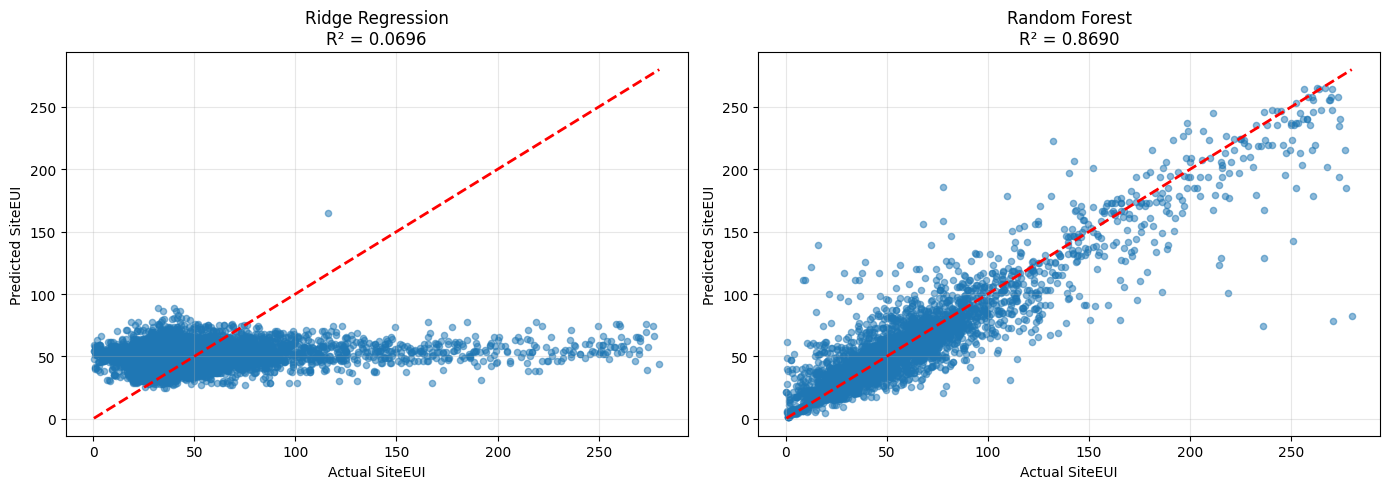

Final predictions visualization complete


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicted vs Actual - Ridge
axes[0].scatter(y_test, y_pred_ridge_final, alpha=0.5, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual SiteEUI')
axes[0].set_ylabel('Predicted SiteEUI')
axes[0].set_title(f'Ridge Regression\nR² = {ridge_final_r2:.4f}')
axes[0].grid(alpha=0.3)

# Predicted vs Actual - Random Forest
axes[1].scatter(y_test, y_pred_rf_final, alpha=0.5, s=20)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual SiteEUI')
axes[1].set_ylabel('Predicted SiteEUI')
axes[1].set_title(f'Random Forest\nR² = {rf_final_r2:.4f}')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Final predictions visualization complete")